## CRISP-DM Phase 3. Data Preparation

The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the modeling tool(s)] from the initial raw data. Tasks include table, record, and attribute selection, as well as transformation and cleaning of data for modeling tools

In [1]:
import sys
sys.path.append('../src')
import utils
import data_processor
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import warnings 
warnings.filterwarnings('ignore')

# Load data
df: pd.DataFrame = utils.load_original_data()

# Data preprocessing object
processor = data_processor.DataProcessor(df)

### Converting Target Variable into binary values in conformance with a classification problem

In [2]:
# Convert Financial Distress column into 0 or 1
df['Financial Distress'] = [0 if x > -0.50 else 1 for x in df['Financial Distress']]

df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [3]:
# Create feature matrix and target vector 
X, y = processor.create_feature_matrix_and_target_vector("Financial Distress")

### Balancing Data

Two different techniques were combined to address class imbalance:
- SMOTE: Oversample the minority class  
- Random Undersampling: Undersample the majority class 

Counter({0: 3536, 1: 136})


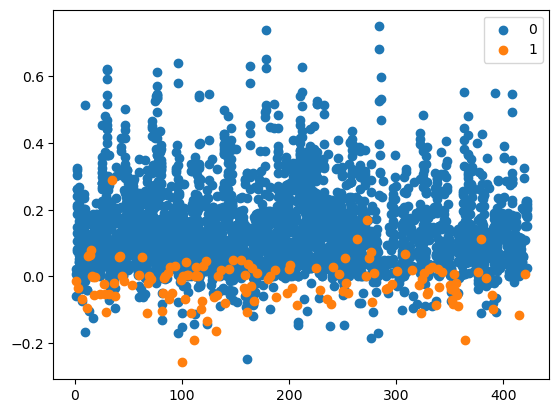

In [68]:
# Check class distribution
processor.class_distribution(X,y)

Counter({0: 2120, 1: 1060})


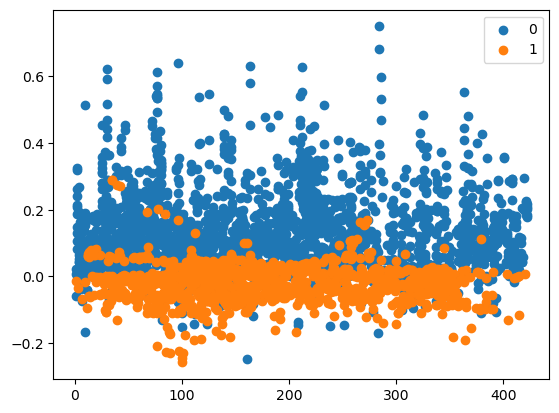

In [4]:
# Transform data with SMOTE for minority class and RandomUnderSampler for majority class to tackle class imbalance
X_sampled, y_sampled = processor.transform(X, y,0.3,0.5)

 The final class distribution after this sequence of transforms matches expectations with a 1:2 ratio or about 2,000 examples in the majority class and about 1,000 examples in the minority class.

In [28]:
sampled_sorted = X_sampled.sort_values(by=['Company'])
sampled_sorted

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
3,1,4,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
0,1,1,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,0.006423,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,-0.081423,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
13,2,10,1.7232,0.208630,0.53398,0.78651,0.293030,0.329800,1.35480,0.265260,...,100.000,100.00,100.000,17.125,14.5,-7.0,29,2.282600,16,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,422,14,1.6148,0.176760,0.36369,0.18442,0.169550,0.197860,1.58420,0.958450,...,91.700,227.50,214.500,21.000,20.5,8.6,37,0.611030,8,45
3669,422,12,1.7099,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,0.971860,...,87.100,175.90,178.100,20.000,14.5,-20.2,37,0.482410,6,43
3665,422,8,2.0609,0.149950,0.18973,0.14381,0.132120,0.199190,1.98920,1.042700,...,84.660,73.20,63.880,16.000,12.0,1.2,37,0.351440,2,39
3668,422,11,1.9615,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,1.000100,...,91.500,130.50,132.400,20.000,14.5,-16.0,37,0.438020,5,42


In [20]:
# check if Time is monotonic and increasing for each group/company 
print("Time monotonic and increasing for each group/company in original data: {}".format(processor.check_time_monotonicity(X, "Time")))
print("Time monotonic and increasing for each group/company in sampled data: {}".format(processor.check_time_monotonicity(X_sampled, "Time")))

Time monotonic and increasing for each group/company in original data: True
Time monotonic and increasing for each group/company in sampled data: False


- It seems that the temporal order of the 'Time' column is not being preserved within each group (company) in the sampled data.

In [5]:
# Preserve temporal order of data for each group/company
X_sampled_sorted = X_sampled.sort_values(by=['Company', 'Time'])
print(X_sampled_sorted.head())

# sort y_sampled according to X_sampled_sorted 
y_sampled_sorted = y_sampled[X_sampled_sorted.index]
print(y_sampled_sorted.head())

   Company  Time      x1        x2       x3       x4        x5        x6  \
0        1     1  1.2810  0.022934  0.87454  1.21640  0.060940  0.188270   
1        1     2  1.2700  0.006454  0.82067  1.00490 -0.014080  0.181040   
2        1     3  1.0529 -0.059379  0.92242  0.72926  0.020476  0.044865   
3        1     4  1.1131 -0.015229  0.85888  0.80974  0.076037  0.091033   
4        2     1  1.0623  0.107020  0.81460  0.83593  0.199960  0.047800   

        x7        x8  ...      x74    x75     x76     x77   x78  x79  x80  \
0  0.52510  0.018854  ...   85.437  27.07  26.102  16.000  16.0  0.2   22   
1  0.62288  0.006423  ...  107.090  31.31  30.194  17.000  16.0  0.4   22   
2  0.43292 -0.081423  ...  120.870  36.07  35.273  17.000  15.0 -0.2   22   
3  0.67546 -0.018807  ...   54.806  39.80  38.377  17.167  16.0  5.6   22   
4  0.74200  0.128030  ...   85.437  27.07  26.102  16.000  16.0  0.2   29   

        x81  x82  x83  
0  0.060390   30   49  
1  0.010636   31   50  
2 -0.455

### Scaling

In [8]:
X_scaled : pd.DataFrame = processor.scale(X_sampled_sorted)
X_scaled

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,-1.603748,-1.533500,-0.003024,-0.482521,1.137950,0.794451,-0.389887,0.549879,-0.220485,-0.036072,...,-0.110648,-0.963890,-0.936790,-0.861074,0.315422,0.352853,0.376909,-0.433941,1.856028,1.214814
1,-1.603748,-1.286123,-0.012310,-0.614362,0.835983,0.373178,-0.975612,0.514784,-0.099016,-0.036074,...,1.217236,-0.896783,-0.871802,-0.355494,0.315422,0.378396,0.376909,-0.466260,1.968299,1.293983
2,-1.603748,-1.038747,-0.195578,-1.141035,1.406340,-0.175852,-0.705813,-0.146237,-0.334998,-0.036088,...,2.062304,-0.821446,-0.791139,-0.355494,-0.044198,0.301765,0.376909,-0.769360,2.080569,1.373151
3,-1.603748,-0.791371,-0.144759,-0.787830,1.050168,-0.015549,-0.272016,0.077872,-0.033697,-0.036078,...,-1.989115,-0.762411,-0.741842,-0.271062,0.315422,1.042530,0.376909,-0.684537,2.192839,1.452320
4,-1.594838,-1.533500,-0.187643,0.190176,0.801958,0.036617,0.695524,-0.131990,0.048964,-0.036055,...,-0.110648,-0.963890,-0.936790,-0.861074,0.315422,0.352853,1.390195,0.339461,-0.726192,-0.526894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,2.147496,0.692887,0.823835,0.957147,-2.865311,-1.258176,0.508220,0.599052,1.889515,-0.035905,...,0.782437,0.190381,0.236837,-0.292297,-0.224007,-0.566717,2.548236,-0.189703,-1.063003,0.581466
3176,2.147496,0.940263,0.571430,1.065548,-2.637841,-1.197345,0.723866,0.557646,1.534971,-0.035919,...,0.261169,0.673107,0.751405,1.161245,-0.224007,-1.716179,2.548236,-0.188638,-0.950733,0.660634
3177,2.147496,1.187640,0.359038,0.997787,-2.299214,-1.202185,0.646415,0.528618,1.226390,-0.035924,...,-0.008664,1.391657,1.477199,1.161245,-0.224007,-2.252595,2.548236,-0.159803,-0.838463,0.739803
3178,2.147496,1.435016,0.231654,0.817625,-2.041811,-1.243854,0.478317,0.464494,1.038931,-0.035926,...,0.347025,1.823737,1.896477,2.172405,2.473138,1.144704,2.548236,-0.147877,-0.726192,0.818971


### Spliting Data ------ Beta Dev ---------------

In [33]:
class TimeSeriesCrossValidator:
    def __init__(self, X:pd.DataFrame, y:pd.DataFrame, n_splits:int=5) -> None:
        """
        Constructor for TimeSeriesCrossValidator class
        :param X: Feature matrix
        :param y: Target vector
        :param n_splits: Number of splits
        :return: None
        """
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.groups = self.X.groupby('Company').groups
        self.group_indexes = self._get_group_indexes()
        print(" Group Indexes:")
        print(self.group_indexes)
        print("-----------------------")
        self.indexes = self._get_indexes()
        print(" Indexes:")
        print(self.indexes)

    def _get_group_indexes(self) -> list[list[int]]:
        """
        Get the indexes for each group
        :return: List of indexes for each group
        """
        group_indexes = []
        for group in self.groups:
            group_indexes.append(self.groups[group].tolist())
        return group_indexes

    def _get_indexes(self) -> list[list[int]]:
        """
        Get the indexes for each split 
        :return: List of indexes for each split
        """
        indexes = []
        for i in range(self.n_splits):
            indexes.append([])
        for group_index in self.group_indexes:
            for i in range(self.n_splits):
                indexes[i].extend(group_index[i::self.n_splits]) # group_index[i::self.n_splits] is the same as group_index[i], group_index[i+self.n_splits], group_index[i+2*self.n_splits], ...
        return indexes

    def split(self) -> tuple:
        """
        Split the data into train and test sets
        :return: Train and test sets
        """
        for i in range(self.n_splits):
            train_indexes = [index for j, index in enumerate(self.indexes) if j != i]
            train_indexes = [item for sublist in train_indexes for item in sublist]
            test_indexes = self.indexes[i]
            yield self.X.iloc[train_indexes], self.X.iloc[test_indexes], self.y.iloc[train_indexes], self.y.iloc[test_indexes]

    def evaluate(self, model:object, scoring:str='accuracy') -> list[float]:
        """
        Evaluate the model using cross validation
        :param model: Model to be evaluated
        :param scoring: Scoring metric
        :return: List of scores
        """
        scores = []
        for X_train, X_test, y_train, y_test in self.split():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            scores.append(accuracy_score(y_test, y_pred))
        return scores
    
# with TimeSeriesCrossValidator class, we can now split data into train and test sets to model time series data with cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a TimeSeriesCrossValidator object
tscv = TimeSeriesCrossValidator(X_scaled, y, n_splits=5)

# Evaluate the model
scores = tscv.evaluate(rf)
print('Scores:', scores)

import numpy as np
print('Mean Score:', np.mean(scores))

# Create a confusion matrix
y_pred = rf.predict(X_scaled)
confusion_matrix(y, y_pred)


 Group Indexes:
[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], [18], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71], [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85], [86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113], [114, 115, 116, 117, 118, 119, 120, 121, 122], [123], [124, 125], [126, 127, 128, 129, 130, 131, 132, 133], [134, 135, 136, 137, 138, 139], [140, 141, 142, 143, 144], [145, 146, 147, 148, 149, 150, 151, 152, 153], [154, 155, 156, 157, 158, 159], [160, 161, 162], [163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176], [177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190], [191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204], [205, 206, 207, 208, 209

array([[3535,    1],
       [  15,  121]], dtype=int64)

### Feature Extraction and Selection

RFE (To Do)

### Save Data

In [9]:
# Append X and Y to create a single data frame
df_model = pd.DataFrame(X_scaled)
df_model['Financial Distress'] = y_sampled_sorted

# save data
with open('../data/processed/financial_data_processed.pkl', 'wb') as f:
    pkl.dump(df_model, f)